In [117]:
!pip install h5py
!pip install pytorch-lightning


In [118]:
# ...existing code...
"""
Pipeline completo para clasificación de videos de danza Balinesa
Adaptado para Visual Studio Code con sistema de caché de frames
"""

import os
import cv2
import pickle
import random
import numpy as np
import h5py
from pathlib import Path
from tqdm import tqdm
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchmetrics import Accuracy

# Configurar semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Librerías importadas exitosamente")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
print(f"Semilla configurada: {SEED}")
# ...existing code...


Librerías importadas exitosamente
PyTorch version: 2.7.1+cu118
CUDA disponible: True
Semilla configurada: 42


In [ ]:
# Configuración de rutas - Adaptado para Windows/Visual Studio Code
BASE_DIR = r'video\Dasar-Gerakan-Tari-Bali-All-Women'
CACHE_DIR = r'video\frame_cache'

# Crear directorio de caché si no existe
os.makedirs(CACHE_DIR, exist_ok=True)

# Configuración del modelo
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 16
NUM_FRAMES = 8  # Número de frames a extraer por video
LEARNING_RATE = 1e-3
MAX_EPOCHS = 80

# Mapeo de clases
LABEL_TO_INT = {
    'Agem_Kanan': 0, 'Agem_Kiri': 1, 'Ngeed': 2, 'Ngegol': 3,
    'Ngelo': 4, 'Ngelung': 5, 'Ngeseh': 6, 'Ngumbang': 7,
    'Nyalud': 8, 'Nyeregseg': 9, 'Seledet': 10, 'Tapak_Sirangpada': 11,
    'Ulap_Ulap': 12
}

INT_TO_LABEL = {v: k for k, v in LABEL_TO_INT.items()}
NUM_CLASSES = len(LABEL_TO_INT)

print(f"Base directory: {BASE_DIR}")
print(f"Cache directory: {CACHE_DIR}")
print(f"Número de clases: {NUM_CLASSES}")
print(f"Clases: {list(LABEL_TO_INT.keys())}")


Base directory: c:\Users\Kotler\Documents\nuevo\lab_2_deep\video\Dasar-Gerakan-Tari-Bali-All-Women
Cache directory: c:\Users\Kotler\Documents\nuevo\lab_2_deep\video\frame_cache
Número de clases: 13
Clases: ['Agem_Kanan', 'Agem_Kiri', 'Ngeed', 'Ngegol', 'Ngelo', 'Ngelung', 'Ngeseh', 'Ngumbang', 'Nyalud', 'Nyeregseg', 'Seledet', 'Tapak_Sirangpada', 'Ulap_Ulap']


In [120]:
# Funciones para extraer y cachear frames de videos

def extract_frames_from_video(video_path, num_frames=8, img_size=(128, 128)):
    """
    Extrae un número fijo de frames uniformemente distribuidos de un video
    """
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: No se puede abrir el video {video_path}")
        return None
    
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames < num_frames:
        # Si el video tiene menos frames, repetir el último
        frame_indices = list(range(total_frames)) + [total_frames - 1] * (num_frames - total_frames)
    else:
        # Seleccionar frames uniformemente distribuidos
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        
        if ret:
            # Redimensionar y normalizar
            frame = cv2.resize(frame, img_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        else:
            # Si falla, usar el último frame válido o uno negro
            if frames:
                frames.append(frames[-1])
            else:
                frames.append(np.zeros((*img_size, 3), dtype=np.uint8))
    
    cap.release()
    return np.array(frames)


def get_cache_path(video_path, cache_dir):
    """
    Genera la ruta del archivo de caché para un video
    """
    # Crear un nombre único basado en la ruta relativa del video
    rel_path = os.path.relpath(video_path, BASE_DIR)
    cache_name = rel_path.replace(os.sep, '_').replace('.mp4', '.npy')
    return os.path.join(cache_dir, cache_name)


def load_or_extract_frames(video_path, cache_dir, num_frames=8, img_size=(128, 128)):
    """
    Carga frames desde caché o los extrae del video y los cachea
    """
    cache_path = get_cache_path(video_path, cache_dir)
    
    # Intentar cargar desde caché
    if os.path.exists(cache_path):
        try:
            frames = np.load(cache_path)
            return frames
        except Exception as e:
            print(f"Error cargando caché {cache_path}: {e}")
    
    # Si no existe caché, extraer frames
    frames = extract_frames_from_video(video_path, num_frames, img_size)
    
    if frames is not None:
        # Guardar en caché
        try:
            os.makedirs(os.path.dirname(cache_path), exist_ok=True)
            np.save(cache_path, frames)
        except Exception as e:
            print(f"Error guardando caché {cache_path}: {e}")
    
    return frames

print("Funciones de extracción y caché de frames definidas")


Funciones de extracción y caché de frames definidas


In [121]:
# Dataset personalizado con caché de frames

class VideoFrameDataset(Dataset):
    def __init__(self, split='train', base_dir=BASE_DIR, cache_dir=CACHE_DIR, 
                 num_frames=NUM_FRAMES, img_size=IMAGE_SIZE, label_map=LABEL_TO_INT):
        """
        Dataset para cargar frames de videos con sistema de caché
        
        Args:
            split: 'train', 'val', o 'test'
            base_dir: Directorio base con las carpetas train/val/test
            cache_dir: Directorio donde se guardan los frames cacheados
            num_frames: Número de frames a extraer por video
            img_size: Tamaño de las imágenes (alto, ancho)
            label_map: Diccionario de mapeo clase -> índice
        """
        self.split = split
        self.base_dir = base_dir
        self.cache_dir = cache_dir
        self.num_frames = num_frames
        self.img_size = img_size
        self.label_map = label_map
        
        # Transformaciones para normalización
        self.transform = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        # Cargar lista de videos
        self.video_paths = []
        self.labels = []
        self._load_video_list()
        
        print(f"Dataset {split}: {len(self.video_paths)} videos cargados")
    
    def _load_video_list(self):
        """Carga la lista de videos y sus etiquetas"""
        split_dir = os.path.join(self.base_dir, self.split)
        
        if not os.path.exists(split_dir):
            print(f"Error: No existe el directorio {split_dir}")
            return
        
        # Iterar por cada clase
        for class_name, label_idx in self.label_map.items():
            class_dir = os.path.join(split_dir, class_name)
            
            if not os.path.exists(class_dir):
                print(f"Advertencia: No existe el directorio {class_dir}")
                continue
            
            # Obtener todos los videos .mp4
            video_files = glob(os.path.join(class_dir, "*.mp4"))
            
            for video_path in video_files:
                self.video_paths.append(video_path)
                self.labels.append(label_idx)
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]
        
        # Cargar frames (desde caché o extrayendo)
        frames = load_or_extract_frames(
            video_path, 
            self.cache_dir, 
            self.num_frames, 
            self.img_size
        )
        
        if frames is None:
            # Si hay error, retornar tensor vacío
            frames = np.zeros((self.num_frames, *self.img_size, 3), dtype=np.uint8)
        
        # Aplicar transformaciones a cada frame
        frames_tensor = torch.stack([self.transform(frame) for frame in frames])
        
        return frames_tensor, label

print("Clase VideoFrameDataset definida")


Clase VideoFrameDataset definida


In [122]:
# DataModule de PyTorch Lightning

class VideoDataModule(pl.LightningDataModule):
    def __init__(self, base_dir=BASE_DIR, cache_dir=CACHE_DIR, 
                 batch_size=BATCH_SIZE, num_frames=NUM_FRAMES, 
                 img_size=IMAGE_SIZE, label_map=LABEL_TO_INT, num_workers=4):
        super().__init__()
        self.base_dir = base_dir
        self.cache_dir = cache_dir
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.img_size = img_size
        self.label_map = label_map
        self.num_workers = num_workers
    
    def setup(self, stage=None):
        """Inicializar los datasets"""
        if stage == 'fit' or stage is None:
            self.train_dataset = VideoFrameDataset(
                split='train',
                base_dir=self.base_dir,
                cache_dir=self.cache_dir,
                num_frames=self.num_frames,
                img_size=self.img_size,
                label_map=self.label_map
            )
            
            self.val_dataset = VideoFrameDataset(
                split='val',
                base_dir=self.base_dir,
                cache_dir=self.cache_dir,
                num_frames=self.num_frames,
                img_size=self.img_size,
                label_map=self.label_map
            )
        
        if stage == 'test' or stage is None:
            self.test_dataset = VideoFrameDataset(
                split='test',
                base_dir=self.base_dir,
                cache_dir=self.cache_dir,
                num_frames=self.num_frames,
                img_size=self.img_size,
                label_map=self.label_map
            )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

print("VideoDataModule definido")


VideoDataModule definido


In [123]:
# Modelo CNN3D para clasificación de videos

class CNN3DClassifier(nn.Module):
    """
    Red neuronal convolucional 3D para clasificación de videos
    Procesa secuencias de frames con convoluciones temporales
    """
    def __init__(self, num_classes=NUM_CLASSES, num_frames=NUM_FRAMES):
        super().__init__()
        
        # Capas convolucionales 3D
        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn1 = nn.BatchNorm3d(64)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn2 = nn.BatchNorm3d(128)
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv3 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn3 = nn.BatchNorm3d(256)
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        self.conv4 = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.bn4 = nn.BatchNorm3d(512)
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        
        # Adaptive pooling para manejar diferentes tamaños
        self.adaptive_pool = nn.AdaptiveAvgPool3d((1, 4, 4))
        
        # Capas fully connected
        self.fc1 = nn.Linear(512 * 1 * 4 * 4, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        # x shape: (batch, num_frames, channels, height, width)
        # Reordenar a (batch, channels, num_frames, height, width)
        x = x.permute(0, 2, 1, 3, 4)
        
        # Convoluciones 3D
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        # Pooling adaptativo
        x = self.adaptive_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

print("Modelo CNN3DClassifier definido")


Modelo CNN3DClassifier definido


In [124]:
# Lightning Module para entrenamiento

class VideoClassifierLightning(pl.LightningModule):
    def __init__(self, num_classes=NUM_CLASSES, num_frames=NUM_FRAMES, learning_rate=LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()
        
        # Modelo
        self.model = CNN3DClassifier(num_classes=num_classes, num_frames=num_frames)
        
        # Loss y métricas
        self.criterion = nn.CrossEntropyLoss()
        self.train_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        self.test_accuracy = Accuracy(task='multiclass', num_classes=num_classes)
        
        # Para almacenar predicciones del test
        self.test_preds = []
        self.test_labels = []
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        frames, labels = batch
        logits = self(frames)
        loss = self.criterion(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        acc = self.train_accuracy(preds, labels)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        frames, labels = batch
        logits = self(frames)
        loss = self.criterion(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        acc = self.val_accuracy(preds, labels)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        frames, labels = batch
        logits = self(frames)
        loss = self.criterion(logits, labels)
        
        preds = torch.argmax(logits, dim=1)
        acc = self.test_accuracy(preds, labels)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        
        # Guardar predicciones para matriz de confusión
        self.test_preds.append(preds.cpu())
        self.test_labels.append(labels.cpu())
        
        return loss
    
    def on_test_epoch_end(self):
        # Concatenar todas las predicciones
        all_preds = torch.cat(self.test_preds).numpy()
        all_labels = torch.cat(self.test_labels).numpy()
        
        # Guardar para análisis posterior
        self.final_preds = all_preds
        self.final_labels = all_labels
        
        # Limpiar
        self.test_preds.clear()
        self.test_labels.clear()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        
        # Learning rate scheduler
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

print("VideoClassifierLightning definido")


VideoClassifierLightning definido


In [125]:
# Crear instancias del DataModule y el modelo

# DataModule
data_module = VideoDataModule(
    base_dir=BASE_DIR,
    cache_dir=CACHE_DIR,
    batch_size=BATCH_SIZE,
    num_frames=NUM_FRAMES,
    img_size=IMAGE_SIZE,
    label_map=LABEL_TO_INT,
    num_workers=0  # Usar 0 en Windows para evitar problemas de multiprocessing
)

# Inicializar datasets
data_module.setup('fit')

# Verificar que los datos se cargaron correctamente
print(f"\nEstadísticas del dataset:")
print(f"  Train: {len(data_module.train_dataset)} videos")
print(f"  Val: {len(data_module.val_dataset)} videos")

# Modelo
model = VideoClassifierLightning(
    num_classes=NUM_CLASSES,
    num_frames=NUM_FRAMES,
    learning_rate=LEARNING_RATE
)

print(f"\nModelo creado con {NUM_CLASSES} clases")
print(f"Parámetros del modelo: {sum(p.numel() for p in model.parameters()):,}")


Dataset train: 1115 videos cargados
Dataset val: 277 videos cargados

Estadísticas del dataset:
  Train: 1115 videos
  Val: 277 videos

Modelo creado con 13 clases
Parámetros del modelo: 8,982,413


# Entrenamiento del Modelo

En esta sección configuraremos el entrenador de PyTorch Lightning con callbacks y comenzaremos el entrenamiento.

**Características del entrenamiento:**
- Sistema de caché: Los frames se extraen y guardan en el primer epoch, los siguientes epochs usan el caché
- Early stopping: Detiene el entrenamiento si no hay mejora
- Model checkpointing: Guarda el mejor modelo basado en val_loss
- Learning rate reduction: Reduce el learning rate cuando el val_loss se estanca


In [ ]:
# Configurar callbacks y entrenador

# Directorio para guardar logs y checkpoints
log_dir = r'video\lightning_logs'
checkpoint_dir = r'video\checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename='best_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    mode='min',
    save_top_k=1,
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
)

# Logger
csv_logger = CSVLogger(log_dir, name='video_classifier')

# Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=csv_logger,
    accelerator='auto',  # Usa GPU si está disponible
    devices=1,
    log_every_n_steps=10,
    enable_progress_bar=True
)

print("Trainer configurado")
print(f"Usando dispositivo: {trainer.strategy.root_device}")
print(f"Logs guardados en: {log_dir}")
print(f"Checkpoints guardados en: {checkpoint_dir}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Trainer configurado
Usando dispositivo: cuda:0
Logs guardados en: c:\Users\Kotler\Documents\nuevo\lab_2_deep\video\lightning_logs
Checkpoints guardados en: c:\Users\Kotler\Documents\nuevo\lab_2_deep\video\checkpoints


In [127]:
# Iniciar entrenamiento

print("="*80)
print("INICIANDO ENTRENAMIENTO")
print("="*80)
print("\nNOTA: En el primer epoch, los frames se extraerán y guardarán en caché.")
print("Los siguientes epochs cargarán los frames desde el caché, acelerando el entrenamiento.\n")

# Entrenar el modelo
trainer.fit(model, data_module)

print("\n" + "="*80)
print("ENTRENAMIENTO COMPLETADO")
print("="*80)
print(f"\nMejor modelo guardado en: {checkpoint_callback.best_model_path}")
print(f"Mejor val_loss: {checkpoint_callback.best_model_score:.4f}")


c:\Users\Kotler\anaconda3\envs\deep\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:751: Checkpoint directory C:\Users\Kotler\Documents\nuevo\lab_2_deep\video\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


INICIANDO ENTRENAMIENTO

NOTA: En el primer epoch, los frames se extraerán y guardarán en caché.
Los siguientes epochs cargarán los frames desde el caché, acelerando el entrenamiento.

Dataset train: 1115 videos cargados
Dataset val: 277 videos cargados



  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | CNN3DClassifier    | 9.0 M  | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params
35.930    Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Kotler\anaconda3\envs\deep\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Kotler\anaconda3\envs\deep\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\Kotler\anaconda3\envs\deep\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.



ENTRENAMIENTO COMPLETADO

Mejor modelo guardado en: C:\Users\Kotler\Documents\nuevo\lab_2_deep\video\checkpoints\best_model-epoch=74-val_loss=0.03.ckpt
Mejor val_loss: 0.0307


In [128]:
# Evaluar en el conjunto de test

# Cargar el mejor modelo
data_module.setup('test')
print(f"Test dataset: {len(data_module.test_dataset)} videos\n")

# Hacer test
print("Evaluando en el conjunto de test...")
test_results = trainer.test(model, data_module, ckpt_path=checkpoint_callback.best_model_path)

print("\nResultados del test:")
print(f"  Test Loss: {test_results[0]['test_loss']:.4f}")
print(f"  Test Accuracy: {test_results[0]['test_acc']:.4f}")


Restoring states from the checkpoint path at C:\Users\Kotler\Documents\nuevo\lab_2_deep\video\checkpoints\best_model-epoch=74-val_loss=0.03.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\Kotler\Documents\nuevo\lab_2_deep\video\checkpoints\best_model-epoch=74-val_loss=0.03.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at C:\Users\Kotler\Documents\nuevo\lab_2_deep\video\checkpoints\best_model-epoch=74-val_loss=0.03.ckpt


Dataset test: 348 videos cargados
Test dataset: 348 videos

Evaluando en el conjunto de test...
Dataset test: 348 videos cargados


c:\Users\Kotler\anaconda3\envs\deep\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9885057210922241
        test_loss          0.045968253165483475
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Resultados del test:
  Test Loss: 0.0460
  Test Accuracy: 0.9885


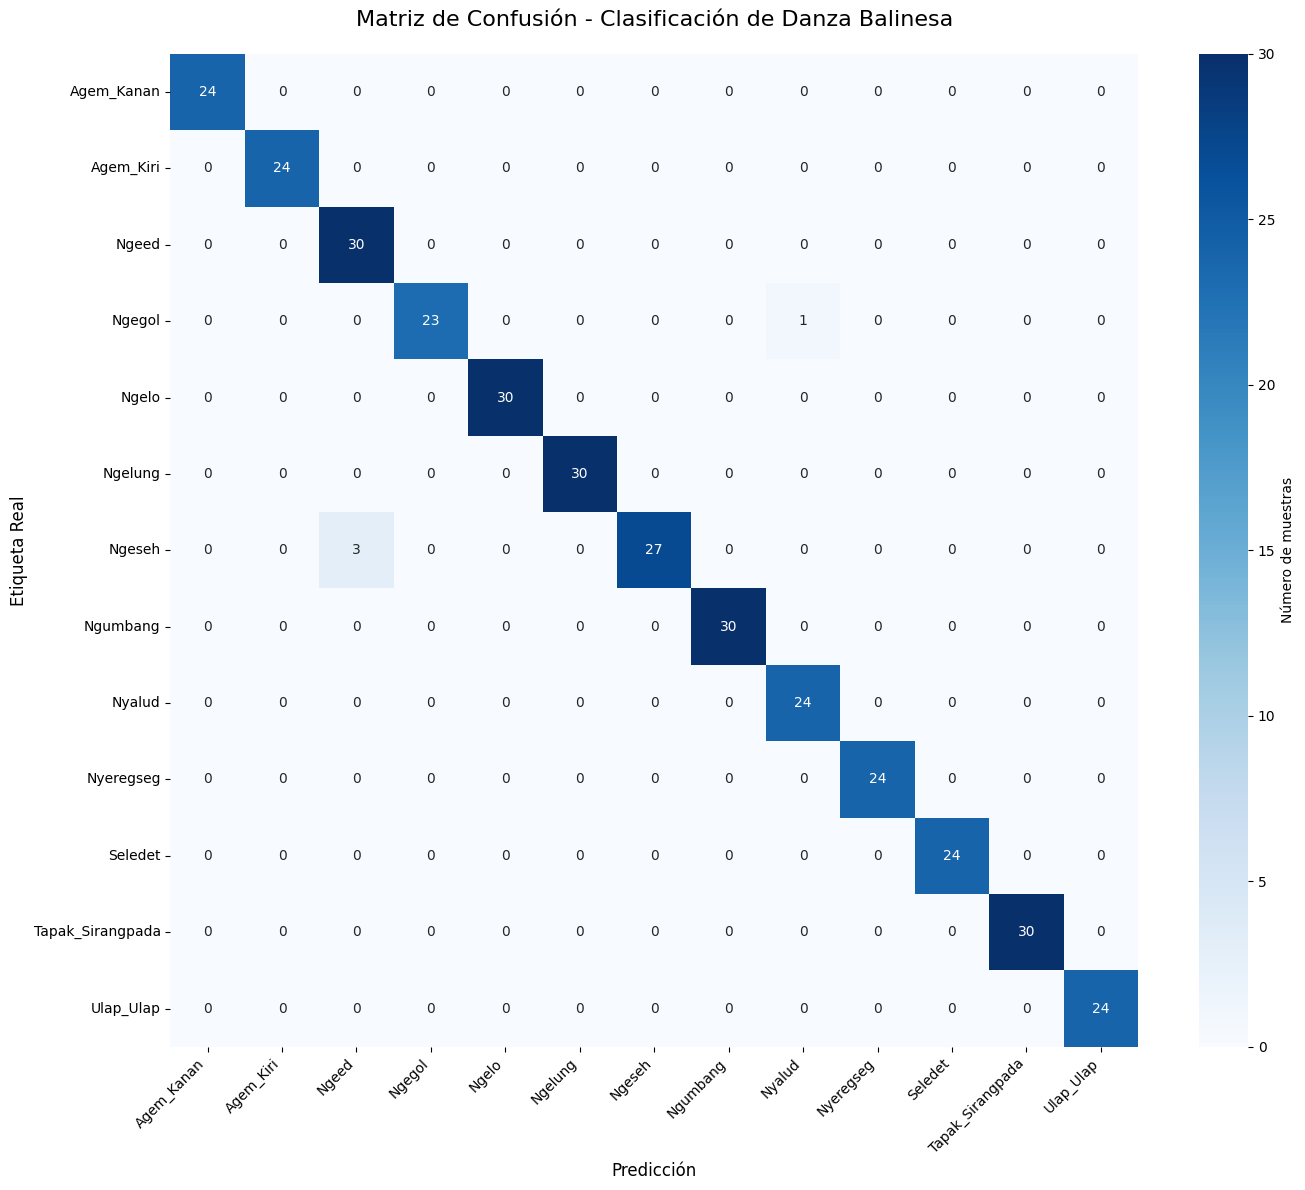


Matriz de confusión guardada en: c:\Users\Kotler\Documents\nuevo\lab_2_deep\video\lightning_logs\confusion_matrix.png


<Figure size 640x480 with 0 Axes>

In [129]:
# Generar matriz de confusión

# Obtener predicciones y etiquetas reales
y_true = model.final_labels
y_pred = model.final_preds

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(LABEL_TO_INT.keys()),
            yticklabels=list(LABEL_TO_INT.keys()),
            cbar_kws={'label': 'Número de muestras'})
plt.title('Matriz de Confusión - Clasificación de Danza Balinesa', fontsize=16, pad=20)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Etiqueta Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Guardar la figura
confusion_matrix_path = os.path.join(log_dir, 'confusion_matrix.png')
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')
print(f"\nMatriz de confusión guardada en: {confusion_matrix_path}")


In [133]:
# Reporte de clasificación detallado

# Generar reporte
report = classification_report(
    y_true, 
    y_pred, 
    target_names=list(LABEL_TO_INT.keys()),
    digits=4
)

print("\n" + "="*80)
print("REPORTE DE CLASIFICACIÓN")
print("="*80)
print(report)

# Guardar reporte en archivo
report_path = os.path.join(log_dir, 'classification_report.txt')
with open(report_path, 'w') as f:
    f.write("REPORTE DE CLASIFICACIÓN\n")
    f.write("="*80 + "\n")
    f.write(report)
print(f"\nReporte guardado en: {report_path}")



REPORTE DE CLASIFICACIÓN
                  precision    recall  f1-score   support

      Agem_Kanan     1.0000    1.0000    1.0000        24
       Agem_Kiri     1.0000    1.0000    1.0000        24
           Ngeed     0.9091    1.0000    0.9524        30
          Ngegol     1.0000    0.9583    0.9787        24
           Ngelo     1.0000    1.0000    1.0000        30
         Ngelung     1.0000    1.0000    1.0000        30
          Ngeseh     1.0000    0.9000    0.9474        30
        Ngumbang     1.0000    1.0000    1.0000        30
          Nyalud     0.9600    1.0000    0.9796        24
       Nyeregseg     1.0000    1.0000    1.0000        24
         Seledet     1.0000    1.0000    1.0000        24
Tapak_Sirangpada     1.0000    1.0000    1.0000        30
       Ulap_Ulap     1.0000    1.0000    1.0000        24

        accuracy                         0.9885       348
       macro avg     0.9899    0.9891    0.9891       348
    weighted avg     0.9894    0.9885    0.9

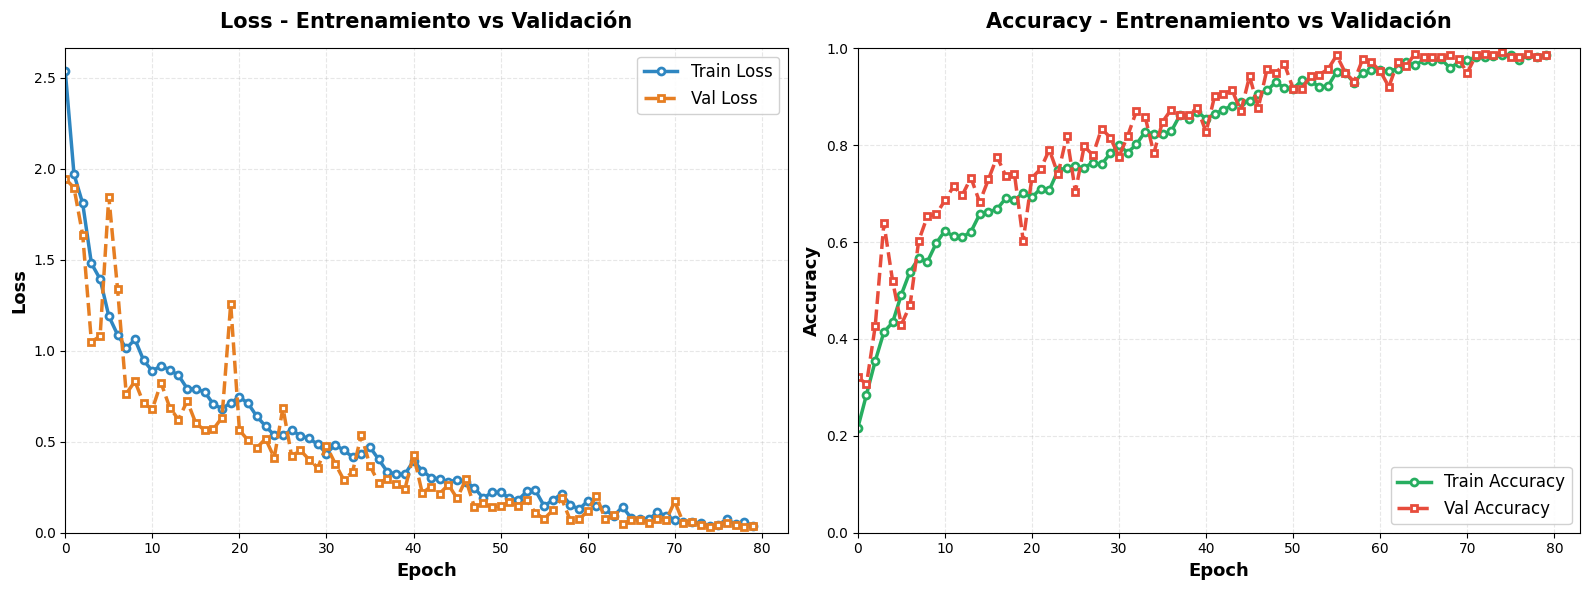


✓ Gráficas de métricas guardadas en: c:\Users\Kotler\Documents\nuevo\lab_2_deep\video\lightning_logs\training_metrics.png
  - Epochs procesados: 81
  - Loss final (train): 0.0380
  - Loss final (val): 0.0355
  - Accuracy final (train): 0.9865
  - Accuracy final (val): 0.9856


In [134]:
# Visualizar curvas de entrenamiento

from glob import glob
import pandas as pd

# Buscar el archivo de métricas más reciente
metrics_files = glob(os.path.join(log_dir, 'video_classifier', 'version_*', 'metrics.csv'))
if metrics_files:
    latest_metrics = max(metrics_files, key=os.path.getctime)
    
    # Cargar métricas
    metrics_df = pd.read_csv(latest_metrics)
    
    # Agrupar por epoch para obtener valores agregados (promedios)
    # Esto elimina el ruido de los valores step-by-step
    epoch_metrics = metrics_df.groupby('epoch').agg({
        'train_loss_epoch': 'first',  # Ya es un valor por epoch
        'train_acc_epoch': 'first',   # Ya es un valor por epoch
        'val_loss': 'first',           # Ya es un valor por epoch
        'val_acc': 'first'             # Ya es un valor por epoch
    }).reset_index()
    
    # Eliminar filas con valores NaN
    epoch_metrics = epoch_metrics.dropna(subset=['epoch'])
    
    # Crear figura con 2 subplots: Loss y Accuracy superpuestos
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfica 1: Loss (Train vs Val superpuestos)
    ax_loss = axes[0]
    
    # Filtrar datos válidos
    train_loss_valid = epoch_metrics[['epoch', 'train_loss_epoch']].dropna()
    val_loss_valid = epoch_metrics[['epoch', 'val_loss']].dropna()
    
    if not train_loss_valid.empty:
        ax_loss.plot(train_loss_valid['epoch'], train_loss_valid['train_loss_epoch'], 
                    marker='o', linestyle='-', color='#2E86C1', label='Train Loss', 
                    linewidth=2.5, markersize=5, markerfacecolor='white', markeredgewidth=2)
    
    if not val_loss_valid.empty:
        ax_loss.plot(val_loss_valid['epoch'], val_loss_valid['val_loss'], 
                    marker='s', linestyle='--', color='#E67E22', label='Val Loss', 
                    linewidth=2.5, markersize=5, markerfacecolor='white', markeredgewidth=2)
    
    ax_loss.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax_loss.set_ylabel('Loss', fontsize=13, fontweight='bold')
    ax_loss.set_title('Loss - Entrenamiento vs Validación', fontsize=15, fontweight='bold', pad=15)
    ax_loss.legend(fontsize=12, loc='upper right', framealpha=0.9)
    ax_loss.grid(True, alpha=0.3, linestyle='--')
    ax_loss.set_xlim(left=0)
    ax_loss.set_ylim(bottom=0)
    
    # Gráfica 2: Accuracy (Train vs Val superpuestos)
    ax_acc = axes[1]
    
    # Filtrar datos válidos
    train_acc_valid = epoch_metrics[['epoch', 'train_acc_epoch']].dropna()
    val_acc_valid = epoch_metrics[['epoch', 'val_acc']].dropna()
    
    if not train_acc_valid.empty:
        ax_acc.plot(train_acc_valid['epoch'], train_acc_valid['train_acc_epoch'], 
                   marker='o', linestyle='-', color='#27AE60', label='Train Accuracy', 
                   linewidth=2.5, markersize=5, markerfacecolor='white', markeredgewidth=2)
    
    if not val_acc_valid.empty:
        ax_acc.plot(val_acc_valid['epoch'], val_acc_valid['val_acc'], 
                   marker='s', linestyle='--', color='#E74C3C', label='Val Accuracy', 
                   linewidth=2.5, markersize=5, markerfacecolor='white', markeredgewidth=2)
    
    ax_acc.set_xlabel('Epoch', fontsize=13, fontweight='bold')
    ax_acc.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    ax_acc.set_title('Accuracy - Entrenamiento vs Validación', fontsize=15, fontweight='bold', pad=15)
    ax_acc.legend(fontsize=12, loc='lower right', framealpha=0.9)
    ax_acc.grid(True, alpha=0.3, linestyle='--')
    ax_acc.set_xlim(left=0)
    ax_acc.set_ylim([0, 1.0])
    
    plt.tight_layout()
    plt.show()
    
    # Guardar la figura
    metrics_plot_path = os.path.join(log_dir, 'training_metrics.png')
    fig.savefig(metrics_plot_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"\n✓ Gráficas de métricas guardadas en: {metrics_plot_path}")
    print(f"  - Epochs procesados: {len(epoch_metrics)}")
    print(f"  - Loss final (train): {train_loss_valid.iloc[-1]['train_loss_epoch']:.4f}" if not train_loss_valid.empty else "")
    print(f"  - Loss final (val): {val_loss_valid.iloc[-1]['val_loss']:.4f}" if not val_loss_valid.empty else "")
    print(f"  - Accuracy final (train): {train_acc_valid.iloc[-1]['train_acc_epoch']:.4f}" if not train_acc_valid.empty else "")
    print(f"  - Accuracy final (val): {val_acc_valid.iloc[-1]['val_acc']:.4f}" if not val_acc_valid.empty else "")
else:
    print("No se encontraron archivos de métricas")


RENDIMIENTO POR CLASE
           Clase  Precision   Recall  F1-Score  Soporte
      Agem_Kanan   1.000000 1.000000  1.000000       24
       Agem_Kiri   1.000000 1.000000  1.000000       24
           Ngelo   1.000000 1.000000  1.000000       30
         Ngelung   1.000000 1.000000  1.000000       30
        Ngumbang   1.000000 1.000000  1.000000       30
       Nyeregseg   1.000000 1.000000  1.000000       24
         Seledet   1.000000 1.000000  1.000000       24
Tapak_Sirangpada   1.000000 1.000000  1.000000       30
       Ulap_Ulap   1.000000 1.000000  1.000000       24
          Nyalud   0.960000 1.000000  0.979592       24
          Ngegol   1.000000 0.958333  0.978723       24
           Ngeed   0.909091 1.000000  0.952381       30
          Ngeseh   1.000000 0.900000  0.947368       30

Resultados por clase guardados en: c:\Users\Kotler\Documents\nuevo\lab_2_deep\video\lightning_logs\per_class_results.csv


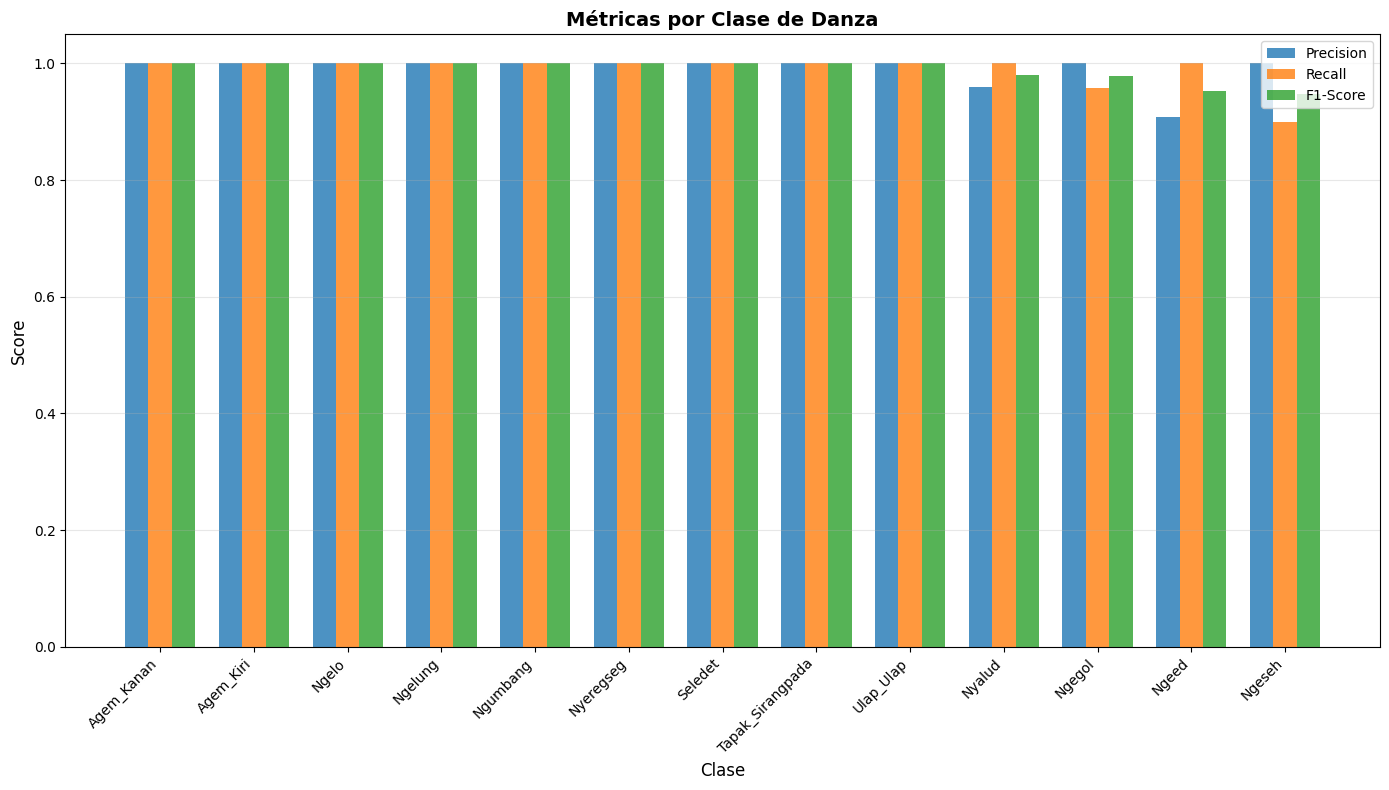


Gráfica de métricas por clase guardada en: c:\Users\Kotler\Documents\nuevo\lab_2_deep\video\lightning_logs\per_class_metrics.png


<Figure size 640x480 with 0 Axes>

In [135]:
# Análisis de rendimiento por clase

from sklearn.metrics import precision_recall_fscore_support

# Calcular métricas por clase
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=list(range(NUM_CLASSES)), zero_division=0
)

# Crear DataFrame con resultados
results_df = pd.DataFrame({
    'Clase': list(LABEL_TO_INT.keys()),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Soporte': support
})

# Ordenar por F1-Score
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("RENDIMIENTO POR CLASE")
print("="*80)
print(results_df.to_string(index=False))

# Guardar resultados
results_path = os.path.join(log_dir, 'per_class_results.csv')
results_df.to_csv(results_path, index=False)
print(f"\nResultados por clase guardados en: {results_path}")

# Visualizar métricas por clase
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(results_df))
width = 0.25

bars1 = ax.bar(x - width, results_df['Precision'], width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, results_df['Recall'], width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, results_df['F1-Score'], width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Clase', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Métricas por Clase de Danza', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results_df['Clase'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Guardar la figura
per_class_plot_path = os.path.join(log_dir, 'per_class_metrics.png')
plt.savefig(per_class_plot_path, dpi=300, bbox_inches='tight')
print(f"\nGráfica de métricas por clase guardada en: {per_class_plot_path}")
